In [40]:
#Basic Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

In [41]:
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

## Import the data and Exploration

In [42]:
#Import the csv file
customer_data=pd.read_csv('ACME-HappinessSurvey2020.csv')
customer_data.head()

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [4]:
customer_data.shape

(126, 7)

In [43]:
#General view of the data
customer_data.describe()

,Y,X1,X2,X3,X4,X5,X6
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,0.547619,4.333333,2.531746,3.309524,3.746032,3.650794,4.253968
std,0.499714,0.800000,1.114892,1.023440,0.875776,1.147641,0.809311
min,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,4.000000,2.000000,3.000000,3.000000,3.000000,4.000000
50%,1.000000,5.000000,3.000000,3.000000,4.000000,4.000000,4.000000
75%,1.000000,5.000000,3.000000,4.000000,4.000000,4.000000,5.000000
max,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [44]:
#Looking for null values
customer_data.isnull().sum()

Y     0
X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
dtype: int64

In [45]:
customer_data.duplicated().any()

True

In [46]:
customer_data[customer_data.duplicated()]

,Y,X1,X2,X3,X4,X5,X6
4,0,5,4,3,3,3,5
22,0,4,3,5,5,5,4
28,1,3,3,1,3,3,4
33,1,3,2,4,4,4,5
37,1,5,3,4,3,4,5
50,1,5,1,3,3,4,4
51,1,5,1,3,3,4,4
53,1,5,2,4,3,4,5
55,1,4,3,2,4,3,4
62,1,5,2,4,4,5,5


In [8]:
(customer_data['Y']==0) & (customer_data['X1']==5) & (customer_data['X2']==4) & (customer_data['X3']==3) & (customer_data['X4']==3) & (customer_data['X5']==3) & (customer_data['X6']==5)

0      False
1      False
2      False
3       True
4       True
       ...  
121    False
122    False
123    False
124    False
125    False
Length: 126, dtype: bool

In [9]:
customer_data[(customer_data['Y']==0) & (customer_data['X1']==5) & (customer_data['X2']==4) & (customer_data['X3']==3) & (customer_data['X4']==3) & (customer_data['X5']==3) & (customer_data['X6']==5)]

,Y,X1,X2,X3,X4,X5,X6
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5


In [49]:
new_customer_data=customer_data.drop_duplicates()
new_customer_data.shape

(110, 7)

In [47]:
#Exploring correlations
customer_data.corr()

,Y,X1,X2,X3,X4,X5,X6
Y,1.000000,0.280160,-0.024274,0.150838,0.064415,0.224522,0.167669
X1,0.280160,1.000000,0.059797,0.283358,0.087541,0.432772,0.411873
X2,-0.024274,0.059797,1.000000,0.184129,0.114838,0.039996,-0.062205
X3,0.150838,0.283358,0.184129,1.000000,0.302618,0.358397,0.203750
X4,0.064415,0.087541,0.114838,0.302618,1.000000,0.293115,0.215888
X5,0.224522,0.432772,0.039996,0.358397,0.293115,1.000000,0.320195
X6,0.167669,0.411873,-0.062205,0.203750,0.215888,0.320195,1.000000


In [50]:
new_customer_data.Y.value_counts()

1    56
0    54
Name: Y, dtype: int64

<b> There are some outliers, but that is to be expected in questionnaires with a limited range of values <b> 

## Using PyCaret: inspecting models

In [52]:
# Requirements
pip install pycaret


You should consider upgrading via the '/Users/paula/.pyenv/versions/3.8.6/envs/lewagon/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [53]:
#Import classification modules
from pycaret.classification import *


In [54]:
#Setup a classification model
class_model = setup(customer_data, 
                       target = 'Y', 
                       session_id=123, 
                       log_experiment=True, 
                       experiment_name='customer_survey')

,Description,Value
0,session_id,123
1,Target,Y
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(126, 7)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,6
8,Ordinal Features,False
9,High Cardinality Features,False


In [55]:
#Retrieve best models
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.6736,0.6869,0.8400,0.6838,0.7467,0.3005,0.3215,0.0160
xgboost,Extreme Gradient Boosting,0.6500,0.6792,0.6833,0.6988,0.6838,0.2830,0.2867,0.1400
rf,Random Forest Classifier,0.6056,0.6719,0.7433,0.6315,0.6771,0.1600,0.1793,0.1570
dt,Decision Tree Classifier,0.6014,0.5858,0.6833,0.6540,0.6590,0.1746,0.1851,0.0120
ridge,Ridge Classifier,0.5931,0.0000,0.7400,0.6000,0.6584,0.1334,0.1619,0.0110
lr,Logistic Regression,0.5819,0.6053,0.7200,0.5952,0.6478,0.1115,0.1337,0.0170
lda,Linear Discriminant Analysis,0.5819,0.5642,0.7033,0.6152,0.6533,0.1242,0.1331,0.0130
svm,SVM - Linear Kernel,0.5806,0.0000,0.6833,0.6328,0.6342,0.0986,0.1060,0.0110
dummy,Dummy Classifier,0.5806,0.5000,1.0000,0.5806,0.7338,0.0000,0.0000,0.0080
gbc,Gradient Boosting Classifier,0.5708,0.6058,0.7000,0.5969,0.6391,0.0885,0.1097,0.0490


In [57]:
#Looking at the best model
print(best_model)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')


In [58]:
#Create a knn model
knn = create_model('knn')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8889,0.9444,1.0000,0.8571,0.9231,0.7273,0.7559
1,0.5556,0.4500,0.6000,0.6000,0.6000,0.1000,0.1000
2,0.5556,0.6000,0.8000,0.5714,0.6667,0.0526,0.0598
3,0.4444,0.5750,0.6000,0.5000,0.5455,-0.1538,-0.1581
4,0.7778,0.8000,1.0000,0.7143,0.8333,0.5263,0.5976
5,0.6667,0.7500,0.8000,0.6667,0.7273,0.3077,0.3162
6,0.4444,0.2500,0.8000,0.5000,0.6154,-0.2162,-0.3162
7,0.7778,1.0000,1.0000,0.7143,0.8333,0.5263,0.5976
8,0.7500,0.6667,1.0000,0.7143,0.8333,0.3846,0.4880


In [60]:
#Instance of second best model
xgboost= create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8333,0.8333,0.8333,0.8333,0.5000,0.5000
1,0.4444,0.4500,0.4000,0.5000,0.4444,-0.0976,-0.1000
2,0.6667,0.6000,0.8000,0.6667,0.7273,0.3077,0.3162
3,0.6667,0.7000,0.6000,0.7500,0.6667,0.3415,0.3500
4,0.7778,0.9500,0.8000,0.8000,0.8000,0.5500,0.5500
5,0.5556,0.7000,0.4000,0.6667,0.5000,0.1429,0.1581
6,0.5556,0.3750,0.6000,0.6000,0.6000,0.1000,0.1000
7,0.5556,0.6500,0.8000,0.5714,0.6667,0.0526,0.0598
8,0.7500,0.6667,0.8000,0.8000,0.8000,0.4667,0.4667


In [127]:
#Instance of 3 best model
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7778,0.8333,0.7143,0.7692,0.1818,0.1890
1,0.4444,0.4000,0.6000,0.5000,0.5455,-0.1538,-0.1581
2,0.5556,0.6000,0.6000,0.6000,0.6000,0.1000,0.1000
3,0.5556,0.7000,0.6000,0.6000,0.6000,0.1000,0.1000
4,0.8889,0.9500,1.0000,0.8333,0.9091,0.7692,0.7906
5,0.4444,0.6000,0.4000,0.5000,0.4444,-0.0976,-0.1000
6,0.3333,0.4250,0.6000,0.4286,0.5000,-0.4211,-0.4781
7,0.6667,0.8000,1.0000,0.6250,0.7692,0.2703,0.3953
8,0.7500,0.7333,1.0000,0.7143,0.8333,0.3846,0.4880


In [108]:
#Tuning the best 3 models
tune_knn=tune_model(knn)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8611,0.8333,0.8333,0.8333,0.5000,0.5000
1,0.4444,0.4000,0.4000,0.5000,0.4444,-0.0976,-0.1000
2,0.7778,0.6250,1.0000,0.7143,0.8333,0.5263,0.5976
3,0.5556,0.7000,0.6000,0.6000,0.6000,0.1000,0.1000
4,0.7778,0.9500,1.0000,0.7143,0.8333,0.5263,0.5976
5,0.7778,0.7000,1.0000,0.7143,0.8333,0.5263,0.5976
6,0.3333,0.3500,0.6000,0.4286,0.5000,-0.4211,-0.4781
7,0.6667,1.0000,1.0000,0.6250,0.7692,0.2703,0.3953
8,0.7500,0.6000,1.0000,0.7143,0.8333,0.3846,0.4880


In [109]:
tune_xgb=tune_model(xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.7778,1.0000,0.6667,0.8000,0.0000,0.0000
1,0.5556,0.4000,1.0000,0.5556,0.7143,0.0000,0.0000
2,0.6667,0.9000,1.0000,0.6250,0.7692,0.2703,0.3953
3,0.5556,0.5500,1.0000,0.5556,0.7143,0.0000,0.0000
4,0.6667,0.8000,1.0000,0.6250,0.7692,0.2703,0.3953
5,0.6667,0.7000,1.0000,0.6250,0.7692,0.2703,0.3953
6,0.5556,0.1750,1.0000,0.5556,0.7143,0.0000,0.0000
7,0.6667,0.8000,1.0000,0.6250,0.7692,0.2703,0.3953
8,0.7500,0.4667,1.0000,0.7143,0.8333,0.3846,0.4880


In [110]:
tune_rf=tune_model(rf)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7778,0.8889,0.8333,0.8333,0.8333,0.5000,0.5000
1,0.2222,0.2500,0.2000,0.2500,0.2222,-0.5366,-0.5500
2,0.6667,0.8000,0.8000,0.6667,0.7273,0.3077,0.3162
3,0.4444,0.5500,0.4000,0.5000,0.4444,-0.0976,-0.1000
4,0.7778,0.8500,0.6000,1.0000,0.7500,0.5714,0.6325
5,0.6667,0.8000,0.6000,0.7500,0.6667,0.3415,0.3500
6,0.4444,0.2750,0.2000,0.5000,0.2857,-0.0465,-0.0598
7,0.5556,0.8000,0.8000,0.5714,0.6667,0.0526,0.0598
8,0.8750,0.7333,1.0000,0.8333,0.9091,0.7143,0.7454


## Feature Importance

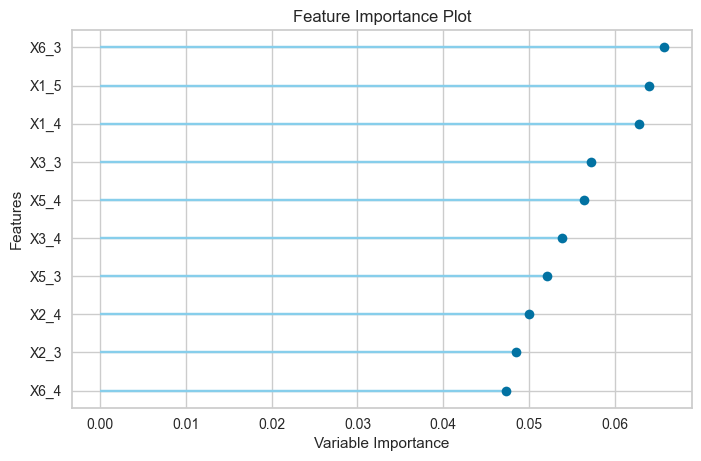

In [73]:
plot_model(rf,plot='feature')

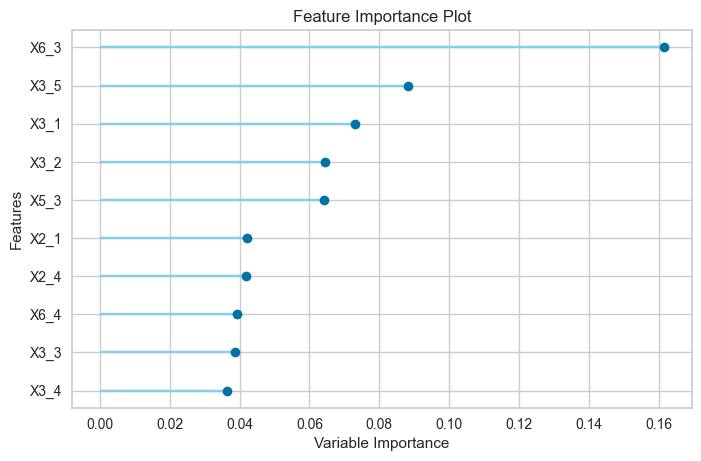

In [86]:
plot_model(xgboost,plot='feature')

In [89]:
pip install shap


     |████████████████████████████████| 436 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 2.4 MB/s eta 0:00:011
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
simpletaxifare 1.0 requires numpy==1.18.5, but you have numpy 1.19.5 which is incompatible.
simpletaxifare 1.0 requires scikit-learn==0.22, but you have scikit-learn 0.23.2 which is incompatible.
simpletaxifare 1.0 requires six==1.15.0, but you have six 1.14.0 which is incompatible.
taxifaremodel 1.0 requires numpy==1.18.5, but you have numpy 1.19.5 which is incompatible.
taxifaremodel 1.0 requires scikit-learn==0.22, but you have scikit-learn 0.23.2 which is incompatible.
You should consider upgrading via the '/Users/paul

In [90]:
#Using SHAP
import shap

In [122]:
from sklearn.model_selection import train_test_split
X = customer_data.drop('Y',axis=1)
X=pd.get_dummies(data=X, columns=['X1','X2','X3','X4','X5','X6'])
y = customer_data['Y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Instantiate Random Forest
random_forest=rf
# Fits the model on the data
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [123]:
# Fits the explainer
explainer = shap.Explainer(random_forest.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

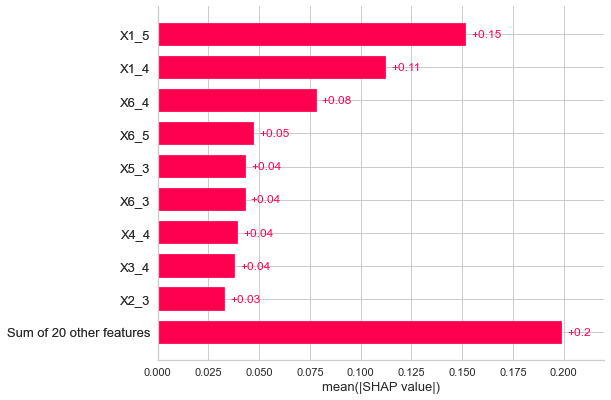

In [124]:
# Plotting the feature importance
shap.plots.bar(shap_values)

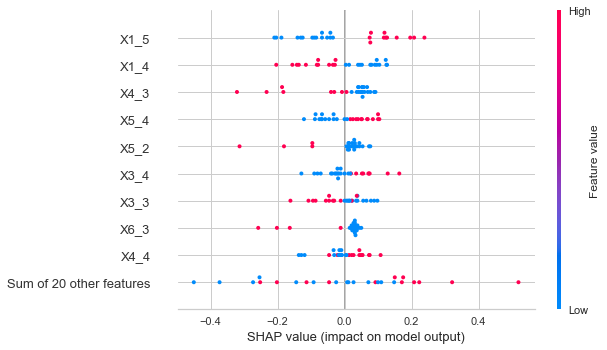

In [105]:
# Taking a look using beeswarm
shap.plots.beeswarm(shap_values)

<b> While the feature importance differs between xgboost and random forest, both have the X6 variable (app makes it order easy for me) with 3 rating as the most important feature. <br>
In the case of random forest, it's by far the most important, while for xgboost it's more scattered. </br>
While using SHAP values, good scores in X1 (ordered delivered on time) explain 20% of the prediction. 

## Model evaluation

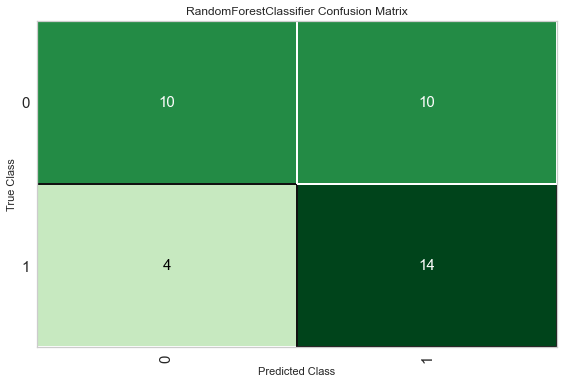

In [82]:
# Plotting confusion matrix
plot_model(rf,plot='confusion_matrix')

In [106]:
# Predict to double check on 3 main models

In [116]:
predict_model(knn)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.5263,0.5639,0.7778,0.5000,0.6087,0.0757,0.0882


,X1_1,X1_3,X1_4,X1_5,X2_1,X2_2,X2_3,X2_4,X2_5,X3_1,...,X5_3,X5_4,X5_5,X6_1,X6_3,X6_4,X6_5,Y,Label,Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.8
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.6
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.6
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.6
6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0,0.6
7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.8
8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0.8
9,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,0.8


In [119]:
predict_model(xgboost)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5789,0.5764,0.7778,0.5385,0.6364,0.1739,0.1910


,X1_1,X1_3,X1_4,X1_5,X2_1,X2_2,X2_3,X2_4,X2_5,X3_1,...,X5_3,X5_4,X5_5,X6_1,X6_3,X6_4,X6_5,Y,Label,Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.9563
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.9862
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.9699
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.5567
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.7099
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.8500
6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0,0.8670
7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.9325
8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,1,0.7230
9,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,0.7835


In [128]:
predict_model(rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6316,0.5917,0.7778,0.5833,0.6667,0.2732,0.2875


,X1_1,X1_3,X1_4,X1_5,X2_1,X2_2,X2_3,X2_4,X2_5,X3_1,...,X5_3,X5_4,X5_5,X6_1,X6_3,X6_4,X6_5,Y,Label,Score
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0.8400
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.8875
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.7850
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0.5017
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.5800
5,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1,0.7700
6,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0,0.8200
7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,1,0.8900
8,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0.5200
9,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,1,0.8500


<b> Random Forest performs better on unseen data and it also has lower variance than the other two

## Conclusion and recommendation

### <b> Bottomline, a target of 73% couldn't be reached. Removing features will only decrease the score. While creating feature engineering can add more multicollinearity <b>

### My choice would be the Random Forest classifier. While KNN and XGBoost have better initial performance, they don't perform as well on unseen data and have higher variance.

### Score will increase as we have more data available or more questions added. Model selection could change by then

## Supplemental

In [1674]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [1675]:
vif_data = pd.DataFrame()
vif_data["feature"] = scaled_X_df.columns
vif_data["VIF"] = [variance_inflation_factor(scaled_X_df.values, i) for i in range(len(scaled_X_df.columns))]

In [1676]:
vif_data

,feature,VIF
0,X1,20.696149
1,X2,2.967404
2,X3,7.807500
3,X4,11.154815
4,X5,8.978936
5,X6,19.039965


In [1006]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

In [1677]:
results=cross_validate(KNeighborsClassifier(),scaled_X_df,y,return_train_score=True)

In [1678]:
kn_scores_best = cross_val_score(KNeighborsClassifier(), X, y, scoring='accuracy', cv=cv, n_jobs=-1)
kn_best_score =np.mean(kn_scores_best)
kn_best_score

0.49206349206349204

In [1537]:
results['train_score'].mean()

0.7182178217821782

In [1538]:
results['test_score'].mean()

0.5323076923076923

In [1539]:
from sklearn.linear_model import RidgeClassifier

In [1679]:
ridge_scores_best = cross_val_score(RidgeClassifier(), X, y, scoring='accuracy', cv=cv, n_jobs=-1)
ridge_best_score =np.mean(ridge_scores_best)
ridge_best_score

0.5396825396825397

In [1541]:
results['train_score'].mean()

0.6130495049504951

In [1542]:
results['test_score'].mean()

0.564

In [1121]:
customer_data

,Y,X1,X2,X3,X4,X5,X6
0,0,3,3,3,4,2,4
1,0,3,2,3,5,4,3
2,1,5,3,3,3,3,5
3,0,5,4,3,3,3,5
4,0,5,4,3,3,3,5
...,...,...,...,...,...,...,...
121,1,5,2,3,4,4,3
122,1,5,2,3,4,2,5
123,1,5,3,3,4,4,5
124,0,4,3,3,4,4,5


In [1142]:
boolean=(customer_data['X6']>=4) & (customer_data['X1']>=4) & (customer_data['X5']>=4) & (customer_data['Y']==0)

<AxesSubplot:xlabel='X6', ylabel='Count'>

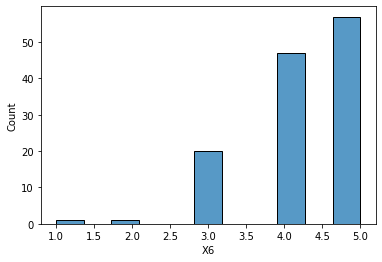

In [1543]:
sns.histplot(customer_data['X6'])

In [1680]:
from sklearn.ensemble import IsolationForest

In [1681]:
forest=IsolationForest()

In [1682]:
metrics_df

,X1,X2,X3,X4,X5,X6,anomaly
0,3,3,3,4,2,4,1
1,3,2,3,5,4,3,1
2,5,3,3,3,3,5,1
3,5,4,3,3,3,5,1
4,5,4,3,3,3,5,1
...,...,...,...,...,...,...,...
121,5,2,3,4,4,3,1
122,5,2,3,4,2,5,1
123,5,3,3,4,4,5,1
124,4,3,3,4,4,5,1


In [1683]:
metrics_df=customer_data.drop('Y',axis=1)

In [1684]:
metrics_df.columns
#specify the 12 metrics column names to be modelled
to_model_columns=metrics_df.columns
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.04), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(metrics_df[to_model_columns])
pred = clf.predict(metrics_df[to_model_columns])
metrics_df['anomaly']=pred
outliers=metrics_df.loc[metrics_df['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(metrics_df['anomaly'].value_counts())

 1    121
-1      5
Name: anomaly, dtype: int64


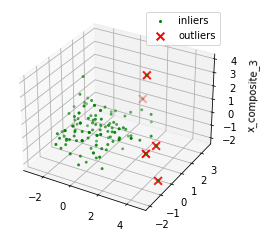

In [1685]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(metrics_df[to_model_columns])
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()


In [1686]:
from sklearn.cluster import DBSCAN

In [1701]:
scan=DBSCAN(eps=2,min_samples=2).fit(X)

In [1702]:
scan.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0])

In [1703]:
scan.get_params

<bound method BaseEstimator.get_params of DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=2, n_jobs=None, p=None)>

In [1704]:
aux_data=customer_data
aux_data

,Y,X1,X2,X3,X4,X5,X6,noise
0,0,3,3,3,4,2,4,0
1,0,3,2,3,5,4,3,0
2,1,5,3,3,3,3,5,0
3,0,5,4,3,3,3,5,0
4,0,5,4,3,3,3,5,0
...,...,...,...,...,...,...,...,...
121,1,5,2,3,4,4,3,0
122,1,5,2,3,4,2,5,0
123,1,5,3,3,4,4,5,0
124,0,4,3,3,4,4,5,0


In [1705]:
aux_data['noise']=scan.labels_

In [1706]:
aux_data[aux_data['noise']==-1]

,Y,X1,X2,X3,X4,X5,X6,noise
34,1,4,1,3,1,1,4,-1
47,0,1,1,1,3,1,4,-1
67,0,4,1,1,3,4,4,-1
119,1,5,5,1,1,5,1,-1


In [1769]:
from sklearn.model_selection import StratifiedKFold

skfold=StratifiedKFold(n_splits=10)

In [1770]:
cross_val_score(svc,X,y,cv=skfold).mean()

0.5576923076923077

In [1771]:
cross_val_score(log_reg,X,y,cv=skfold).mean()

0.5416666666666667

In [1772]:
cross_val_score(best_model,scaled_X_df,y,cv=skfold).mean()

0.6519230769230769

In [1752]:
from sklearn.model_selection import ShuffleSplit


ssplit=ShuffleSplit(n_splits=10,test_size=0.25)

In [1759]:
cross_val_score(log_reg,X,y,cv=ssplit).mean()

0.6

In [1764]:
cross_val_score(ada_boost,X,y,cv=ssplit).mean()

0.5875

In [1763]:
cross_val_score(ada_boost,new_customer_data.drop('Y',axis=1),new_customer_data['Y'],cv=ssplit).mean()

0.6178571428571429

In [1802]:
cross_val_score(svc,X,y,cv=ssplit).mean()

0.565625

In [4]:
from sklearn.mixture import GaussianMixture

In [1805]:
gaussian= GaussianMixture()

In [1810]:
cv

LeaveOneOut()

In [1820]:
from sklearn.tree import DecisionTreeClassifier
tree=DecisionTreeClassifier()

In [1824]:
cross_val_score(tree,X,y,cv=cv).mean()

0.5396825396825397

In [83]:
from sklearn.ensemble import RandomForestClassifier
random_f=RandomForestClassifier(max_depth=3)

In [49]:
cross_val_score(random_f,X,y,cv=cv).mean()

0.6031746031746031

In [78]:
from category_encoders.target_encoder import TargetEncoder

In [79]:
Targetenc = TargetEncoder(cols=X.columns)

In [80]:
X_enc=Targetenc.fit_transform(X, y)

/Users/paula/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [81]:
cross_val_score(ada_boost,X_enc,y,cv=cv).mean()

0.6349206349206349

In [84]:
cross_val_score(random_f,X_enc,y,cv=cv).mean()

0.5317460317460317

In [88]:
cross_val_score(xgb,X_enc,y,cv=cv).mean()

0.5793650793650794

In [89]:
cat = CatBoostClassifier(
    iterations=5, 
    learning_rate=0.1, 
    #loss_function='CrossEntropy'
)



In [90]:
cross_val_score(cat,X_enc,y,cv=cv).mean()

0:	learn: 0.6853732	total: 1.14ms	remaining: 4.57ms
1:	learn: 0.6751005	total: 2.38ms	remaining: 3.56ms
2:	learn: 0.6678916	total: 7.54ms	remaining: 5.02ms
3:	learn: 0.6598853	total: 8.38ms	remaining: 2.1ms
4:	learn: 0.6534892	total: 9.19ms	remaining: 0us
0:	learn: 0.6853732	total: 224us	remaining: 897us
1:	learn: 0.6755564	total: 694us	remaining: 1.04ms
2:	learn: 0.6686048	total: 995us	remaining: 663us
3:	learn: 0.6600287	total: 1.51ms	remaining: 376us
4:	learn: 0.6547944	total: 1.97ms	remaining: 0us
0:	learn: 0.6854102	total: 191us	remaining: 767us
1:	learn: 0.6750017	total: 609us	remaining: 914us
2:	learn: 0.6675975	total: 1.02ms	remaining: 681us
3:	learn: 0.6583108	total: 1.39ms	remaining: 348us
4:	learn: 0.6507582	total: 1.78ms	remaining: 0us
0:	learn: 0.6848540	total: 503us	remaining: 2.01ms
1:	learn: 0.6749412	total: 1.35ms	remaining: 2.03ms
2:	learn: 0.6699882	total: 2.01ms	remaining: 1.34ms
3:	learn: 0.6621403	total: 2.67ms	remaining: 667us
4:	learn: 0.6537777	total: 3.26ms	re

0:	learn: 0.6849128	total: 230us	remaining: 923us
1:	learn: 0.6748920	total: 549us	remaining: 824us
2:	learn: 0.6678713	total: 1.51ms	remaining: 1ms
3:	learn: 0.6597053	total: 1.99ms	remaining: 496us
4:	learn: 0.6524800	total: 2.46ms	remaining: 0us
0:	learn: 0.6848540	total: 206us	remaining: 826us
1:	learn: 0.6748246	total: 713us	remaining: 1.07ms
2:	learn: 0.6679183	total: 1.22ms	remaining: 815us
3:	learn: 0.6599572	total: 1.78ms	remaining: 444us
4:	learn: 0.6527469	total: 2.43ms	remaining: 0us
0:	learn: 0.6849128	total: 192us	remaining: 768us
1:	learn: 0.6755862	total: 756us	remaining: 1.13ms
2:	learn: 0.6691212	total: 1.1ms	remaining: 732us
3:	learn: 0.6623001	total: 1.62ms	remaining: 405us
4:	learn: 0.6538380	total: 2.1ms	remaining: 0us
0:	learn: 0.6848540	total: 261us	remaining: 1.04ms
1:	learn: 0.6741461	total: 761us	remaining: 1.14ms
2:	learn: 0.6682555	total: 1.28ms	remaining: 851us
3:	learn: 0.6596932	total: 1.77ms	remaining: 443us
4:	learn: 0.6525295	total: 2.24ms	remaining: 

1:	learn: 0.6762717	total: 3.28ms	remaining: 4.92ms
2:	learn: 0.6703643	total: 4.07ms	remaining: 2.71ms
3:	learn: 0.6657488	total: 5.27ms	remaining: 1.32ms
4:	learn: 0.6605501	total: 5.66ms	remaining: 0us
0:	learn: 0.6853732	total: 153us	remaining: 615us
1:	learn: 0.6762572	total: 355us	remaining: 533us
2:	learn: 0.6702332	total: 437us	remaining: 291us
3:	learn: 0.6655054	total: 600us	remaining: 150us
4:	learn: 0.6601703	total: 756us	remaining: 0us
0:	learn: 0.6854102	total: 221us	remaining: 886us
1:	learn: 0.6752309	total: 609us	remaining: 913us
2:	learn: 0.6702218	total: 1.62ms	remaining: 1.08ms
3:	learn: 0.6622957	total: 2.73ms	remaining: 681us
4:	learn: 0.6548379	total: 3.69ms	remaining: 0us
0:	learn: 0.6856767	total: 301us	remaining: 1.21ms
1:	learn: 0.6753091	total: 948us	remaining: 1.42ms
2:	learn: 0.6702255	total: 1.48ms	remaining: 989us
3:	learn: 0.6620978	total: 2ms	remaining: 501us
4:	learn: 0.6546661	total: 2.51ms	remaining: 0us
0:	learn: 0.6853732	total: 215us	remaining: 8

0.5476190476190477